# Investigating Dwell Time

## Loading data

In [ ]:
import requests
import pandas as pd
import numpy as np

### Yesterday's full data pulled from api

In [ ]:
url = 'http://sfmta-ds.eba-hqpuyrup.us-east-1.elasticbeanstalk.com/daily-general-json'

In [ ]:
json = requests.get(url, params={'day': '2020-05-24'}).json()

In [ ]:
# making df

df = pd.DataFrame(data=json)

In [ ]:
# paring down to a couple of buses 
# (most reports and second-most reports) 
# on a single route to simplify
# and making sure we're sorted by time (stupid-check)

nbus = df[df['rid']=='NBUS']
nbus_highest = nbus[nbus['vid']==(nbus['vid'].value_counts().index[0])].sort_values('timestamp')
nbus_second = nbus[nbus['vid']==(nbus['vid'].value_counts().index[1])].sort_values('timestamp')

## Engineering Dwell Time In Minutes (sort of)

In [ ]:
def wrangle_bus(df):
  """
  preps dataframe for a single bus
  gives accurate timestamps and naively calculates 
  dwell time as 1min per checkin with motion (kph <= 0)
  """
  times = df['timestamp'].values
  ages = df['age'].values
  df['adjusted_timestamp'] = [pd.Timestamp(times[x]) - pd.Timedelta(seconds=ages[x]) for 
                              x in range(len(df['timestamp']))]
  df['timestamp'] = [pd.Timestamp(times[x]) for x in range(len(df['timestamp']))]

  dwell_count = 0
  dwell_totals = []
  df['dwell'] = 0
  for x in df['kph']:
    if x <= 0:
      dwell_count += 1
      dwell_totals.append(dwell_count)
    elif x > 0:
      dwell_totals.append(0)
      dwell_count = 0
  df['dwell'] = [dwell_totals[x] for x in range(len(df))]

  df = df.drop(columns=['age', 'rid', 'vid'])

  return df

In [ ]:
nums = [2,1,3]

nums.sort()

print(nums)

[1, 2, 3]


In [ ]:
nbus_highest_wrangled = wrangle_bus(nbus_highest)

nbus_highest_wrangled.head()

,timestamp,kph,heading,latitude,longitude,direction,adjusted_timestamp,dwell
9458,2020-05-24 04:09:12,39,345,37.7595,-122.508,None,2020-05-24 04:08:55,0
9516,2020-05-24 04:10:12,8,135,37.7601,-122.509,None,2020-05-24 04:09:55,0
9573,2020-05-24 04:11:12,0,218,37.7602,-122.509,None,2020-05-24 04:10:43,1
9630,2020-05-24 04:12:12,0,218,37.7602,-122.509,None,2020-05-24 04:11:43,2
9687,2020-05-24 04:13:12,0,218,37.7602,-122.509,None,2020-05-24 04:12:42,3


In [ ]:
nbus_second_wrangled = wrangle_bus(nbus_second)

nbus_second_wrangled.head()

,timestamp,kph,heading,latitude,longitude,direction,adjusted_timestamp,dwell
10477,2020-05-24 04:25:12,16,210,37.7838,-122.408,NBUS_O_F00,2020-05-24 04:25:05,0
10560,2020-05-24 04:26:12,0,225,37.7825,-122.410,NBUS_O_F00,2020-05-24 04:26:05,1
10648,2020-05-24 04:27:12,0,225,37.7808,-122.412,NBUS_O_F00,2020-05-24 04:27:05,2
10734,2020-05-24 04:28:13,11,210,37.7799,-122.413,NBUS_O_F00,2020-05-24 04:28:06,0
10820,2020-05-24 04:29:12,0,225,37.7790,-122.414,NBUS_O_F00,2020-05-24 04:29:05,1


## Visualizations


### Inbound

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


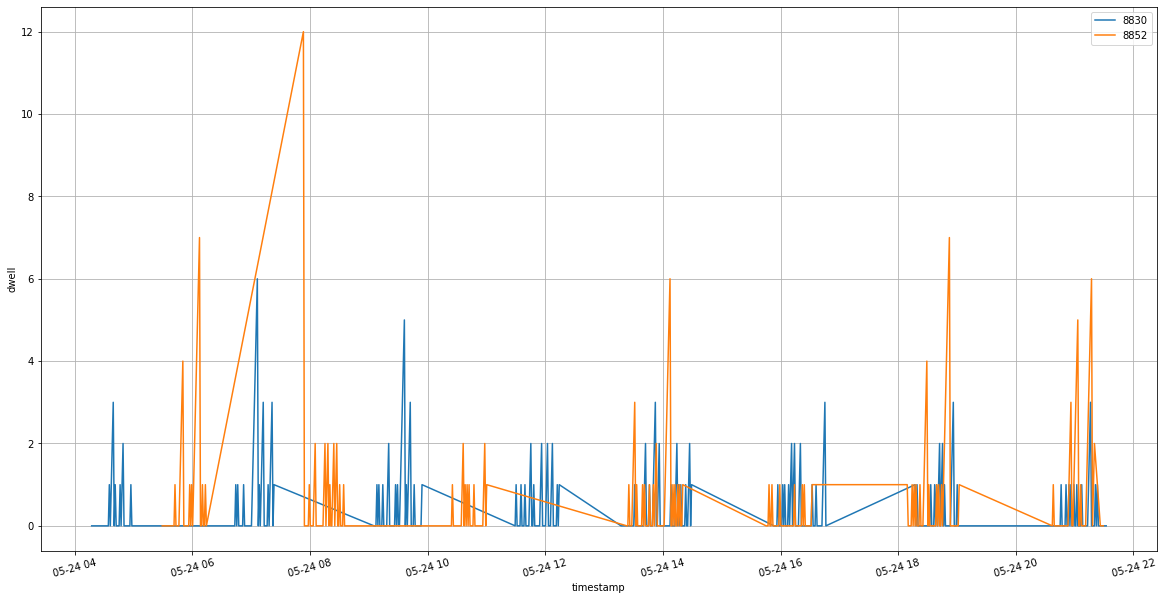

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.xticks(rotation=15)
plt.grid()
sns.lineplot('timestamp', 'dwell', data=nbus_highest_wrangled[nbus_highest_wrangled['direction']=='NBUS_I_F00'])
sns.lineplot('timestamp', 'dwell', data=nbus_second_wrangled[nbus_second_wrangled['direction']=='NBUS_I_F00'])
plt.legend(labels=['8830','8852']);

### Outbound

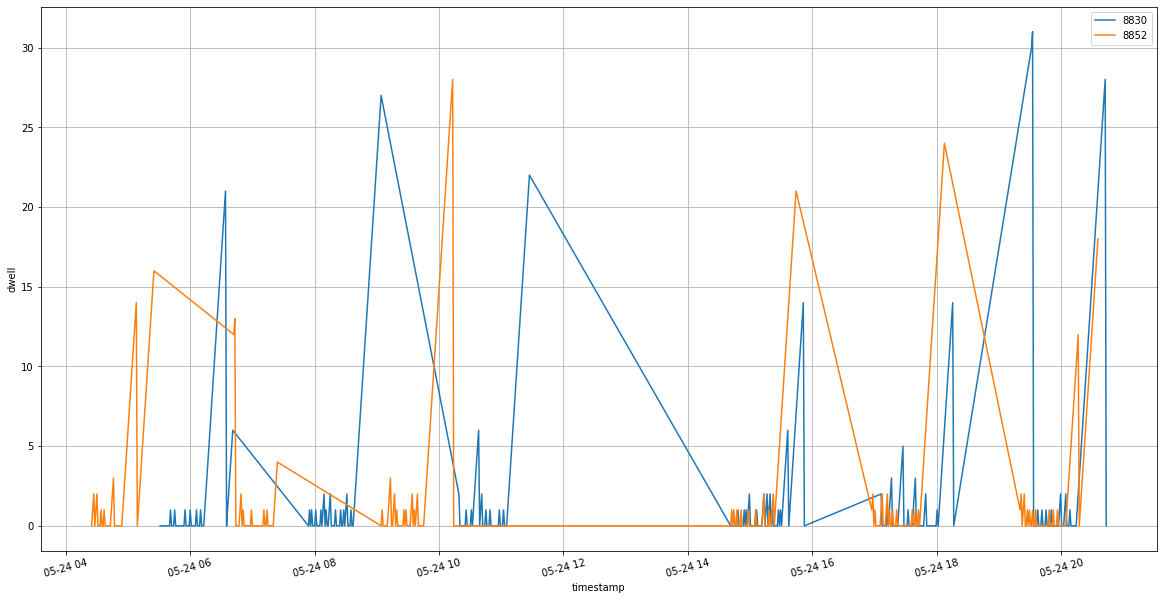

In [ ]:
plt.figure(figsize=(20,10))
plt.xticks(rotation=15)
plt.grid()
sns.lineplot('timestamp', 'dwell', data=nbus_highest_wrangled[nbus_highest_wrangled['direction']=='NBUS_O_F00'])
sns.lineplot('timestamp', 'dwell', data=nbus_second_wrangled[nbus_second_wrangled['direction']=='NBUS_O_F00'])
plt.legend(labels=['8830','8852']);

### Combined

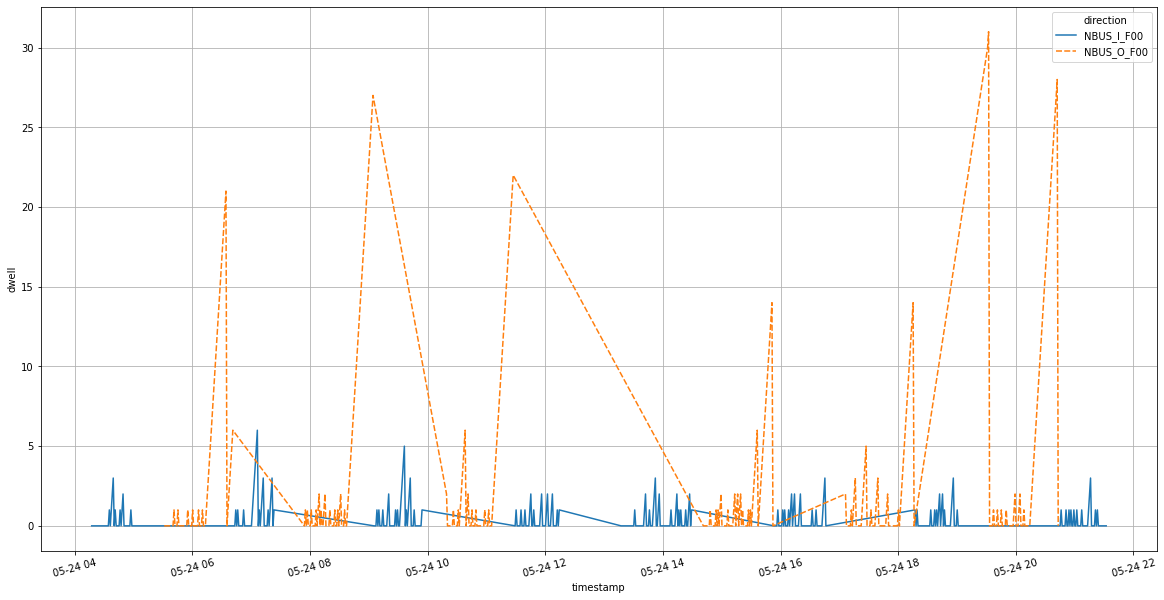

In [ ]:
# bus with most trips

plt.figure(figsize=(20,10))
plt.xticks(rotation=15)
plt.grid()
sns.lineplot('timestamp', 'dwell', data=nbus_highest_wrangled,
             style='direction', hue='direction');

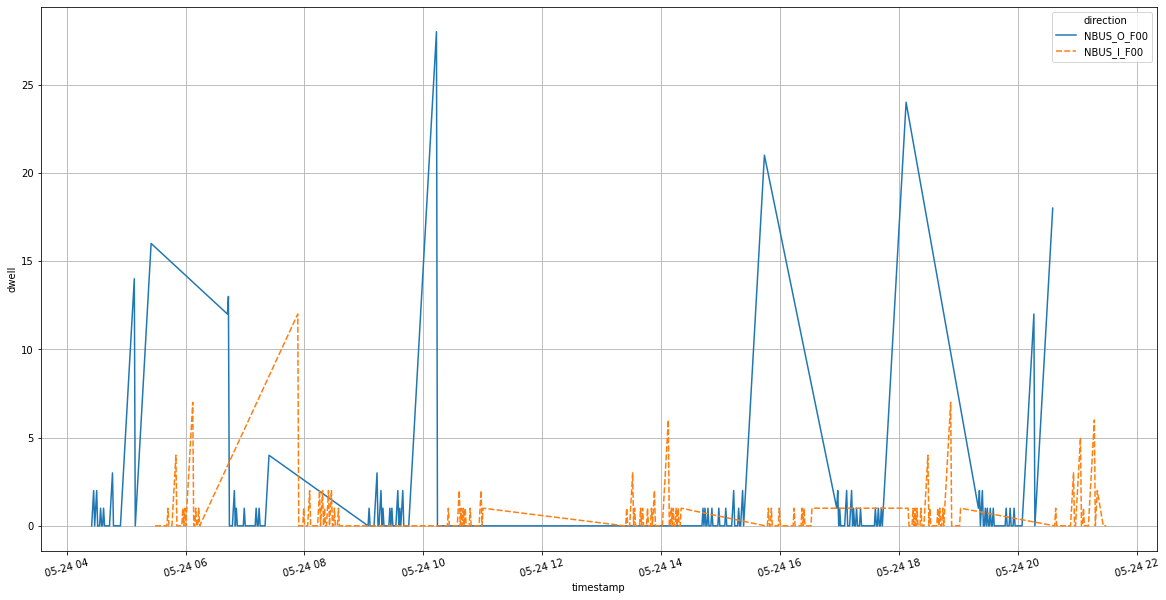

In [ ]:
# bus with second-most trips

plt.figure(figsize=(20,10))
plt.xticks(rotation=15)
plt.grid()
sns.lineplot('timestamp', 'dwell', data=nbus_second_wrangled,
             style='direction', hue='direction');